In [1]:
import cv2
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import smart_resize
import tensorflow
from tensorflow.keras import  Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten, AvgPool2D,MaxPool2D,GlobalAveragePooling2D


import sys
%matplotlib inline

In [2]:
PI, COS, SIN = np.pi, np.cos, np.sin

## Creating dataset and load images

In [3]:
paths = {'dir':'/content/drive/MyDrive/APRO/3'}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv(os.path.join(paths['dir'],'train.csv'))

In [6]:
df.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,25,55,63,39,145,36,171,45,39,...,159,65,113,103,79,148,113,148,143,141
1,04767.jpg,17,32,39,27,56,22,81,16,20,...,86,28,56,66,45,80,59,80,74,76
2,05241.jpg,33,44,70,44,119,41,142,41,33,...,144,56,94,101,74,135,89,135,112,133
3,03849.jpg,96,157,222,143,389,129,517,125,153,...,467,188,328,339,241,451,335,453,419,441
4,00952.jpg,13,19,30,16,51,17,66,16,18,...,59,23,39,43,31,56,41,56,49,55


In [7]:
#select all target columns
target_cols = df.drop(columns = ['filename']).columns.to_list()

In [8]:
df['image'] = df.apply((lambda x: np.array(cv2.imread(os.path.join(paths['dir'],'train', x['filename'])))), axis=1)

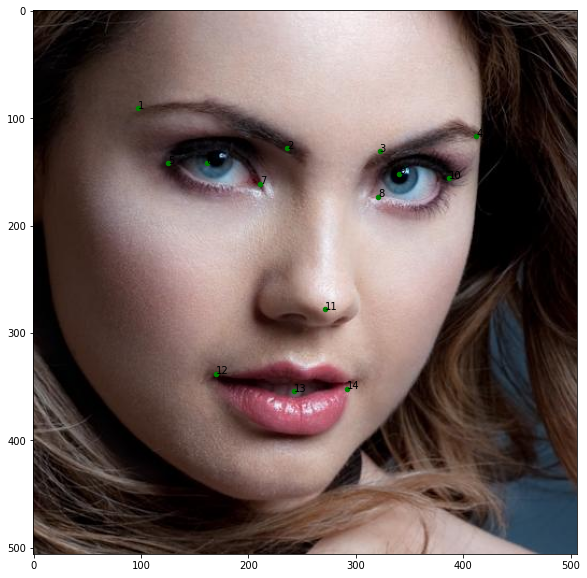

In [9]:
#plt.imshow(train_images[102])
j = 100
x_marks = df[target_cols].iloc[j][::2].to_list()
y_marks = df[target_cols].iloc[j][1::2].to_list()
i = 0
img = df['image'].iloc[j]
plt.figure(figsize = (10,10))
plt.imshow(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), cmap = 'gray')
for i in range(len(x_marks)):

   
   
    plt.scatter(x_marks[i], y_marks[i], s=20, color='green')
    plt.annotate(str(i+1),(x_marks[i], y_marks[i]) )
   
    
    i+=1

points 1,2 - right eyebrow

points 3,4 - left eyebrow

points 5-7 - right eye

points 8-10 - left eyebrow

point 11 - nose

points 12-14 - mouth

Transform target columns based on scale factor

In [10]:
def calculate_angle(row):
    v1 = row['x14'] -row['x12']
    v2 = row['y14'] - row['y12']
    try:
        angle  = int(np.rad2deg(math.atan(v2/v1)))
    except:
        angle = 0
    return angle

In [11]:
df['angle'] = df.apply(calculate_angle, axis =1)

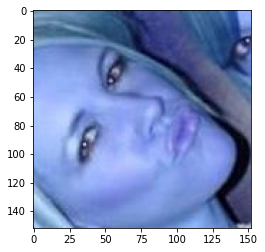

In [12]:
plt.imshow(df[np.abs(df['angle'])>10].loc[25]['image'])

# Prepare data and train the model

## Resize all images and target

In [13]:
#images and resize them
df['image_re'] = df['image'].map((lambda x:  smart_resize(x, (128,128))))
#calculate the scaling factor
df['scale'] = df['image'].apply(lambda x:  (x.shape[0]/128))

In [14]:
for col in target_cols:
    df[col] = df.apply(lambda x: x[col]/x['scale'], axis=1)

In [15]:
features =  np.asarray(df['image_re'].tolist()).astype(np.float32)
target = df[target_cols].to_numpy()
features = features / 255.

In [16]:
#index of images with small angle value
flat_idx = df[abs(df['angle'])<5].index.to_list()

In [17]:
all_columns = df.columns

In [18]:
import gc
del df
gc.collect( )

3616

## Split data

In [19]:

train_images, valid_images, train_labels, valid_labels = train_test_split(features, target, test_size=0.2, random_state=42)

In [20]:
def pred_show(model, valid_images, valid_labels):

    '''
    This function demostrates 16 random images and show mean squared error for valid data 
    '''
    
    pred = model.predict(valid_images)
    print('MSE:',mean_squared_error(pred, valid_labels))
    x_marks=pred[0::2]
    y_marks=pred[1::2]
    x_true = valid_labels[0::2]
    y_true = valid_labels[1::2]
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
    axes = axes.ravel()
    i = 0
    t = pred[i:16]
    for img in valid_images[0:16]:
        x_marks = t[i][0::2]
        y_marks = t[i][1::2]
        x_true = valid_labels[i][0::2]
        y_true = valid_labels[i][1::2]
        axes[i].imshow(np.array(cv2.cvtColor(valid_images[i], cv2.COLOR_BGR2RGB)), cmap = 'gray')
        axes[i].scatter(x_marks, y_marks, s=10, color='red')
        axes[i].scatter(x_true, y_true, s=10, color='green')
        #print(x_marks[i].shape)
        i+=1
    plt.show()
    return model


# Create tensorflow models

## Simple model

In [24]:
callbacks = [tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=10),
             tensorflow.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.1, patience=5),
             tensorflow.keras.callbacks.ModelCheckpoint('val_loss', save_best_only=True, save_weights_only=True)]

Epoch 1/120
134/134 [==============================] - 5s 28ms/step - loss: 12.0047 - mse: 352.0742 - val_loss: 6.4945 - val_mse: 87.1858 - lr: 0.0010
Epoch 2/120
134/134 [==============================] - 3s 24ms/step - loss: 5.4249 - mse: 60.5906 - val_loss: 4.8955 - val_mse: 59.8867 - lr: 0.0010
Epoch 3/120
134/134 [==============================] - 3s 24ms/step - loss: 4.9657 - mse: 53.0575 - val_loss: 5.3727 - val_mse: 66.7159 - lr: 0.0010
Epoch 4/120
134/134 [==============================] - 3s 23ms/step - loss: 4.9033 - mse: 52.1178 - val_loss: 5.6806 - val_mse: 70.2593 - lr: 0.0010
Epoch 5/120
134/134 [==============================] - 3s 23ms/step - loss: 4.8618 - mse: 51.5821 - val_loss: 4.9657 - val_mse: 59.2933 - lr: 0.0010
Epoch 6/120
134/134 [==============================] - 3s 23ms/step - loss: 5.0194 - mse: 53.6595 - val_loss: 4.9575 - val_mse: 60.6104 - lr: 0.0010
Epoch 7/120
134/134 [==============================] - 3s 23ms/step - loss: 4.8818 - mse: 51.8135 - val_

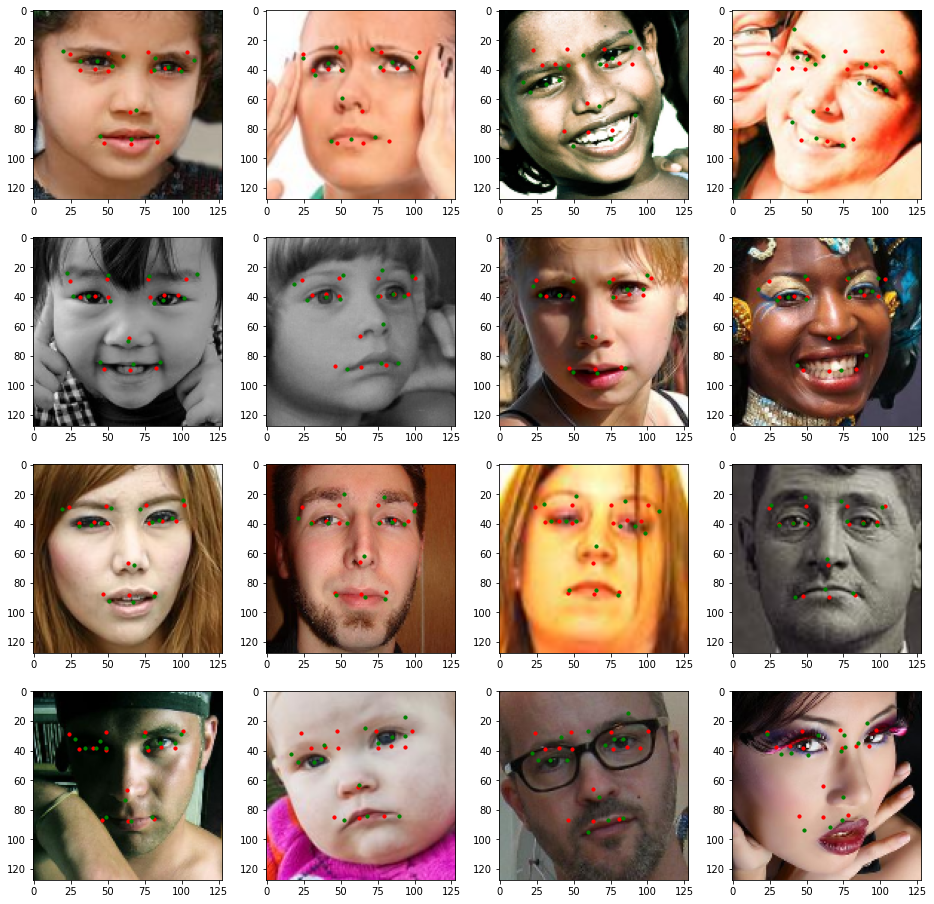

In [25]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same',
                 activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same',
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same',
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))



model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation="relu"))
model.add(Dense(28))

model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['mse'])
model.fit(train_images, train_labels, epochs=120, verbose=1, batch_size=24, callbacks = callbacks, validation_split = 0.2)
pred_show(model,valid_images, valid_labels)

## Add rotate augmentation

In [26]:
def rotate_augmentation(images, keypoints, rotation_angles = [10,20], i =1000):

    '''
    Function for rotation an image and calculating new target values.
    Function select i-number of images from flat_idx and crates new images which are rotated
    
    Args:
        images: numpy array images representation
        keypoints: numpy array keypoints representation
        rotation angles: list of values to rotate image. Each image rotates each of this values and minus each of this values.
        i: amount of new images for each rotation_angles value

    Returns:
        This function returns expanded numpy array of images, and expanded numpy array of keypoints

    '''

    idx = random.sample(flat_idx,k=i)
    images = images[idx]
    keypoints=keypoints[idx]
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((64,64), angle, 1.0)
            angle_rad = -angle*PI/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (128,128), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 64.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*COS(angle_rad)-rotated_keypoint[idx+1]*SIN(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*SIN(angle_rad)+rotated_keypoint[idx+1]*COS(angle_rad)
                rotated_keypoint += 64.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)

    return np.reshape(rotated_images,(-1,128,128,3)), rotated_keypoints


def apply_aug(features,target, func):

    '''
    Function for applying augmentation function

    Args:
        features: numpy array of features
        target: numpy array of keypoints
        func: function for applying

    Returns:
        Function returns changed values of featerus and targets

    '''
    new_train_images, new_train_keypoints = func
    features = np.concatenate((new_train_images,features))
    target = np.concatenate((new_train_keypoints,target))
    target= np.asarray(target)
    return features, target


## Rotate augmentation

We are able to see that the neural network fails more on rotated images, that's why add images in our train data which will be rotated at different angles.

In [27]:
features, target = apply_aug(features,target, rotate_augmentation(features, target, [10,15,20,25,30,40], 200))

Augmenting for angles (in degrees): 
10  -10  15  -15  20  -20  25  -25  30  -30  40  -40  

In [28]:
train_images, valid_images, train_labels, valid_labels = train_test_split(features, target, test_size=0.2, random_state=42)

In [29]:
callbacks = [tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=6),
             tensorflow.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.1, patience=5),
             tensorflow.keras.callbacks.ModelCheckpoint('val_loss', save_best_only=True, save_weights_only=True)]

Epoch 1/150
198/198 [==============================] - 6s 26ms/step - loss: 10.7930 - mse: 271.2499 - val_loss: 7.1415 - val_mse: 103.4604 - lr: 0.0010
Epoch 2/150
198/198 [==============================] - 5s 23ms/step - loss: 6.8123 - mse: 93.6830 - val_loss: 6.5040 - val_mse: 91.4822 - lr: 0.0010
Epoch 3/150
198/198 [==============================] - 5s 23ms/step - loss: 6.6848 - mse: 91.1932 - val_loss: 6.4008 - val_mse: 90.0526 - lr: 0.0010
Epoch 4/150
198/198 [==============================] - 4s 23ms/step - loss: 6.6231 - mse: 90.1413 - val_loss: 6.7608 - val_mse: 94.8752 - lr: 0.0010
Epoch 5/150
198/198 [==============================] - 5s 23ms/step - loss: 5.7376 - mse: 69.2657 - val_loss: 5.8034 - val_mse: 68.9583 - lr: 0.0010
Epoch 6/150
198/198 [==============================] - 5s 23ms/step - loss: 4.9365 - mse: 51.8591 - val_loss: 4.6088 - val_mse: 51.8224 - lr: 0.0010
Epoch 7/150
198/198 [==============================] - 5s 23ms/step - loss: 4.5505 - mse: 46.2985 - val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE: 12.87229244879079


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


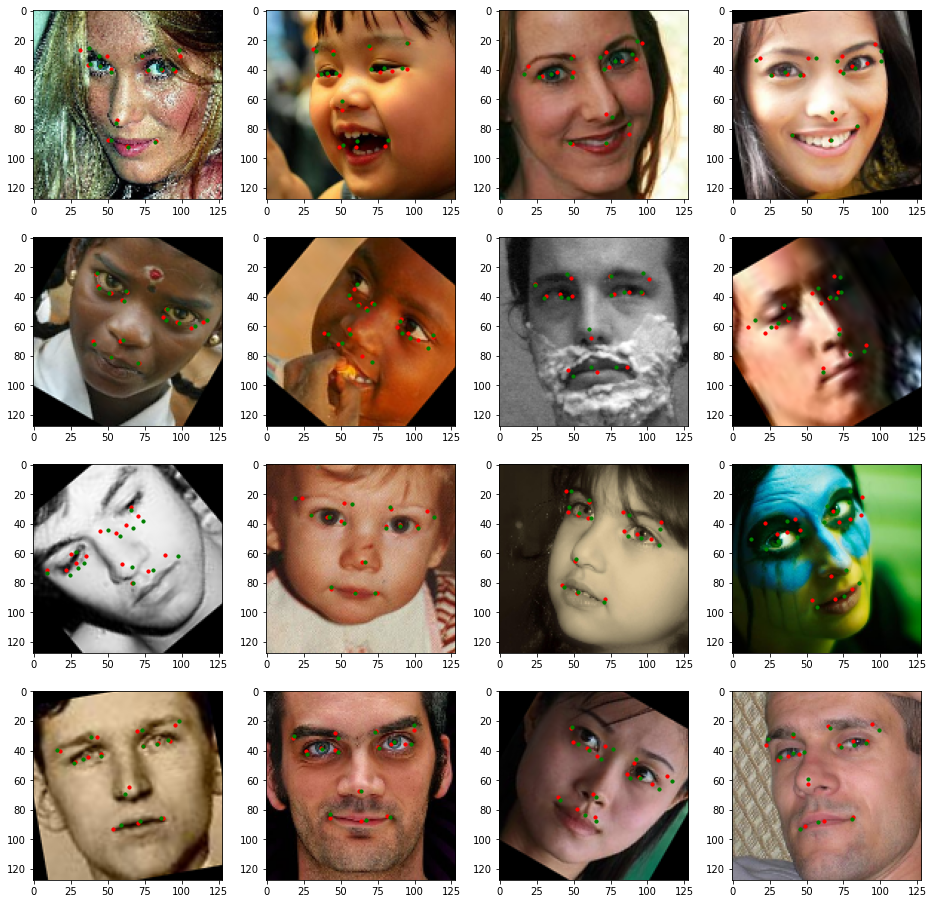

In [30]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same',
                 activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same',
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same',
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

#model.add(Flatten())

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation="relu"))
model.add(Dense(28))

model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['mse'])
model.fit(train_images, train_labels, epochs=150, verbose=1, batch_size=24, callbacks = callbacks, validation_split = 0.2)
pred_show(model,valid_images, valid_labels)

In [31]:
import gc
del model,train_images,train_labels,valid_images,valid_labels
gc.collect( )

40295

As we can see, the mean squared error has decreased after applying the augmentation.